### Install Packages

In [1]:
## install required packages
!pip3 install swig
!pip3 install wrds
!pip3 install pyportfolioopt
!pip3 install yfinance
## install finrl library
!pip3 install git+https://github.com/Saeeedd/FinRL.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/Saeeedd/FinRL.git to /tmp/pip-req-build-22458g3c
  Running command git clone --filter=blob:none --quiet https://github.com/Saeeedd/FinRL.git /tmp/pip-req-build-22458g3c
  Resolved https://github.com/Saeeedd/FinRL.git to commit 0da68c4830fed748182256762d5185f27791a254
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-6sgakdll/elegantrl_73f6a3b301e54a93b5648d6ef26c9f18
  Running command git clone --filter=blob

  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 59fe4b4a1cca0a28e8a5fa4fb80eed9b5d472978
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import sys
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl import config_tickers
from finrl.config import INDICATORS, RESULTS_DIR, TRAINED_MODEL_DIR
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure
from finrl.main import check_and_make_directories

import itertools

%matplotlib inline

/localhome/sza191/.local/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/localhome/sza191/.local/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
2023-08-11 14:47:56.451987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 14:47:56.527526: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from

### Fetching Raw Data

We are using [yfinance](https://github.com/ranaroussi/yfinance) to fetch data from Yahoo Finance platform. It is an open-source library that provides APIs fetching historical data form Yahoo Finance. We use [YahooDownloader] which is implemented in FinRL, using yfinance. 

### Important Data Characteristics
**OHLCV**: Data downloaded from yahoo finance platform are in the form of OHLCV, corresponding to **open, high, low, close, volume,** respectively. OHLCV is important because they contain most of numerical information of a stock in time series.
Almost all of the necessary data for a trader to analyze data could be found in OHLCV data format.

In [3]:
# DJ Most Notable 30 Tickers
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [4]:
# Set start and end data for train & trade
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-01'
TRADE_END_DATE = '2022-3-1'

In [5]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.422928,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.256280,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.254057,7117200,CAT,4


### Preprocess Data
Basically, we need to perform couple of important tasks for making our data ready to be processed
* **Check for missing data**
* **Adding technical indicators**: In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI
* **Adding turbulence index**: Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [7]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)
processed.head()

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3311, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,2.754725,2.754725,39.189999,0.0
1,2009-01-02,58.590000,59.080002,57.750000,43.422928,6547900,AMGN,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,43.422928,43.422928,39.189999,0.0
2,2009-01-02,18.570000,19.520000,18.400000,15.256280,10955700,AXP,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,15.256280,15.256280,39.189999,0.0
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,44.910000,46.980000,44.709999,31.254057,7117200,CAT,4,0.0,2.977272,2.648438,100.0,66.666667,100.0,31.254057,31.254057,39.189999,0.0


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [9]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754725,746015200.0,4.0,0.0,2.977272,2.648438,100.0,66.666667,100.0,2.754725,2.754725,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422928,6547900.0,4.0,0.0,2.977272,2.648438,100.0,66.666667,100.0,43.422928,43.422928,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256280,10955700.0,4.0,0.0,2.977272,2.648438,100.0,66.666667,100.0,15.256280,15.256280,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.977272,2.648438,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254057,7117200.0,4.0,0.0,2.977272,2.648438,100.0,66.666667,100.0,31.254057,31.254057,39.189999,0.0


#### Split and Save data for train and trade 

In [10]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print("train size:", len(train), " trade size: ",len(trade))
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

train size: 80272  trade size:  15747


### Start Training 

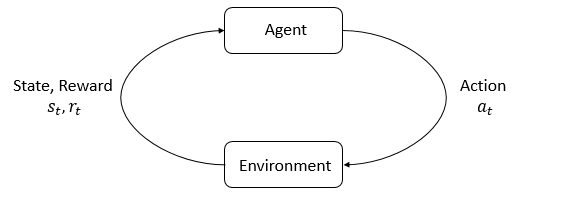

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

### Read Data 

In [11]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 29, State Space: 291
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Train DRL Agents

#### 1) A2C

In [12]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [13]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

---------------------------------------
| time/                 |             |
|    fps                | 182         |
|    iterations         | 100         |
|    time_elapsed       | 2           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -0.23       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 41.6        |
|    reward             | -0.27085245 |
|    std                | 0.999       |
|    value_loss         | 2.03        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 2.38e-07  |
|    learning_rate

---------------------------------------
| time/                 |             |
|    fps                | 221         |
|    iterations         | 1500        |
|    time_elapsed       | 33          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 1499        |
|    policy_loss        | -86.3       |
|    reward             | -0.29694408 |
|    std                | 0.999       |
|    value_loss         | 4.92        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 222       |
|    iterations         | 1600      |
|    time_elapsed       | 36        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 5.96e-08  |
|    learning_rate

--------------------------------------
| time/                 |            |
|    fps                | 223        |
|    iterations         | 2900       |
|    time_elapsed       | 64         |
|    total_timesteps    | 14500      |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | -0.0574    |
|    learning_rate      | 0.0007     |
|    n_updates          | 2899       |
|    policy_loss        | -192       |
|    reward             | -2.3382747 |
|    std                | 1.01       |
|    value_loss         | 74         |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 223       |
|    iterations         | 3000      |
|    time_elapsed       | 66        |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -41.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

-------------------------------------
| time/                 |           |
|    fps                | 225       |
|    iterations         | 4300      |
|    time_elapsed       | 95        |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -41.6     |
|    explained_variance | -0.00212  |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | 260       |
|    reward             | -1.109381 |
|    std                | 1.02      |
|    value_loss         | 42.3      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 225      |
|    iterations         | 4400     |
|    time_elapsed       | 97       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -41.5    |
|    explained_variance | -0.0185  |
|    learning_rate      | 0.0007   |
|    n_updates        

-------------------------------------
| time/                 |           |
|    fps                | 225       |
|    iterations         | 5600      |
|    time_elapsed       | 124       |
|    total_timesteps    | 28000     |
| train/                |           |
|    entropy_loss       | -41.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 5599      |
|    policy_loss        | 18.2      |
|    reward             | 0.5376955 |
|    std                | 1.02      |
|    value_loss         | 0.632     |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 225        |
|    iterations         | 5700       |
|    time_elapsed       | 126        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -41.8      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
| 

----------------------------------------
| time/                 |              |
|    fps                | 225          |
|    iterations         | 7000         |
|    time_elapsed       | 154          |
|    total_timesteps    | 35000        |
| train/                |              |
|    entropy_loss       | -42          |
|    explained_variance | 5.96e-08     |
|    learning_rate      | 0.0007       |
|    n_updates          | 6999         |
|    policy_loss        | 187          |
|    reward             | -0.013238605 |
|    std                | 1.03         |
|    value_loss         | 31.9         |
----------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 225       |
|    iterations         | 7100      |
|    time_elapsed       | 157       |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -42.1     |
|    explained_variance | 0.00624   |
| 

--------------------------------------
| time/                 |            |
|    fps                | 225        |
|    iterations         | 8400       |
|    time_elapsed       | 186        |
|    total_timesteps    | 42000      |
| train/                |            |
|    entropy_loss       | -42.3      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 8399       |
|    policy_loss        | 28.8       |
|    reward             | -0.8126965 |
|    std                | 1.04       |
|    value_loss         | 2.54       |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 225      |
|    iterations         | 8500     |
|    time_elapsed       | 188      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -42.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n

-------------------------------------
| time/                 |           |
|    fps                | 225       |
|    iterations         | 9800      |
|    time_elapsed       | 217       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -42.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 9799      |
|    policy_loss        | 111       |
|    reward             | 2.1175652 |
|    std                | 1.05      |
|    value_loss         | 21.8      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 225      |
|    iterations         | 9900     |
|    time_elapsed       | 219      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -42.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates        

In [14]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c")

#### 2) DDPG

In [15]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")
# set up logger
tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [16]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 196       |
|    time_elapsed    | 56        |
|    total_timesteps | 11072     |
| train/             |           |
|    actor_loss      | 2.95      |
|    critic_loss     | 387       |
|    learning_rate   | 0.001     |
|    n_updates       | 8304      |
|    reward          | 1.4797868 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 186       |
|    time_elapsed    | 118       |
|    total_timesteps | 22144     |
| train/             |           |
|    actor_loss      | -13.9     |
|    critic_loss     | 11.7      |
|    learning_rate   | 0.001     |
|    n_updates       | 19376     |
|    reward          | 1.4797868 |
----------------------------------
day: 2767, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 4233266.21
total_rew

In [17]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg")

#### 3) PPO

In [18]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [19]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000)

------------------------------------
| time/              |             |
|    fps             | 291         |
|    iterations      | 1           |
|    time_elapsed    | 7           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.06389427 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 285          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0144315455 |
|    clip_fraction        | 0.229        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.000168     |
|    learning_rate        | 0.00025      |
|    loss                 | 6.43         |
|    n_updates            | 10           |
|    policy_gradient_l

-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 12          |
|    time_elapsed         | 88          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.017364232 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.8       |
|    explained_variance   | 0.00572     |
|    learning_rate        | 0.00025     |
|    loss                 | 13.1        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.014      |
|    reward               | -0.69664484 |
|    std                  | 1.02        |
|    value_loss           | 30.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 13    

----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 22         |
|    time_elapsed         | 162        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.01933907 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.3      |
|    explained_variance   | -0.00197   |
|    learning_rate        | 0.00025    |
|    loss                 | 40.6       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0135    |
|    reward               | 0.74074256 |
|    std                  | 1.04       |
|    value_loss           | 96.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 23          |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 32         |
|    time_elapsed         | 236        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.01598541 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.6      |
|    explained_variance   | 0.0306     |
|    learning_rate        | 0.00025    |
|    loss                 | 16.8       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0143    |
|    reward               | -2.292002  |
|    std                  | 1.05       |
|    value_loss           | 44.2       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 33         |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 42          |
|    time_elapsed         | 310         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.014847795 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | 0.0874      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.8        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0165     |
|    reward               | 3.6247041   |
|    std                  | 1.06        |
|    value_loss           | 49.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 43       

-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 52          |
|    time_elapsed         | 384         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.020271994 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.0527      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00959    |
|    reward               | -0.06598928 |
|    std                  | 1.08        |
|    value_loss           | 28.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 62          |
|    time_elapsed         | 457         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.031459853 |
|    clip_fraction        | 0.299       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | 0.294       |
|    learning_rate        | 0.00025     |
|    loss                 | 37.6        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00487    |
|    reward               | 1.829326    |
|    std                  | 1.1         |
|    value_loss           | 64.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 63    

-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 72          |
|    time_elapsed         | 530         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.027430672 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.319       |
|    learning_rate        | 0.00025     |
|    loss                 | 39          |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0166     |
|    reward               | -0.17424339 |
|    std                  | 1.11        |
|    value_loss           | 75.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 73    

day: 2767, episode: 100
begin_total_asset: 1000000.00
end_total_asset: 6118448.18
total_reward: 5118448.18
total_cost: 269063.65
total_trades: 73217
Sharpe: 1.110
-----------------------------------------
| time/                   |             |
|    fps                  | 278         |
|    iterations           | 82          |
|    time_elapsed         | 602         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.023128334 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.0577      |
|    learning_rate        | 0.00025     |
|    loss                 | 33.7        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00844    |
|    reward               | 0.34208742  |
|    std                  | 1.13        |
|    value_loss           | 67.1        |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 92         |
|    time_elapsed         | 679        |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.02454989 |
|    clip_fraction        | 0.193      |
|    clip_range           | 0.2        |
|    entropy_loss         | -45        |
|    explained_variance   | 0.0289     |
|    learning_rate        | 0.00025    |
|    loss                 | 19.6       |
|    n_updates            | 910        |
|    policy_gradient_loss | -0.00523   |
|    reward               | 0.8259333  |
|    std                  | 1.14       |
|    value_loss           | 67.1       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 277        |
|    iterations           | 93         |
|    time_elapse

In [20]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo")

#### 4) TD3

In [21]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [22]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 207       |
|    time_elapsed    | 53        |
|    total_timesteps | 11072     |
| train/             |           |
|    actor_loss      | 193       |
|    critic_loss     | 1.11e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 8304      |
|    reward          | 2.3002415 |
----------------------------------
day: 2767, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 5525147.71
total_reward: 4525147.71
total_cost: 999.00
total_trades: 41474
Sharpe: 1.078
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 197       |
|    time_elapsed    | 112       |
|    total_timesteps | 22144     |
| train/             |           |
|    actor_loss      | 80.1      |
|    critic_loss     | 2.87e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 19376     |


In [23]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3")

#### 5) SAC

In [24]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [25]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 115       |
|    time_elapsed    | 96        |
|    total_timesteps | 11072     |
| train/             |           |
|    actor_loss      | 1.71e+03  |
|    critic_loss     | 391       |
|    ent_coef        | 0.271     |
|    ent_coef_loss   | 175       |
|    learning_rate   | 0.0001    |
|    n_updates       | 10971     |
|    reward          | 1.1848682 |
----------------------------------
day: 2767, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 3808842.82
total_reward: 2808842.82
total_cost: 174544.21
total_trades: 70758
Sharpe: 0.850
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 113       |
|    time_elapsed    | 195       |
|    total_timesteps | 22144     |
| train/             |           |
|    actor_loss      | 1.47e+03  |
|    critic_loss     | 727      

In [26]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac")

### Backtesting

In [27]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])n as Theodosius the Great, became emperor in 379. Mark Hebblewhite, ancient historian a
trade.index.names = ['']

trained_a2c = A2C.load("trained_models/agent_a2c") 
trained_ddpg = DDPG.load("trained_models/agent_ddpg")
trained_ppo = PPO.load("trained_models/agent_ppo")
trained_td3 = TD3.load("trained_models/agent_td3")
trained_sac = SAC.load("trained_models/agent_sac")


In [28]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 *  stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [29]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [30]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [31]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!
hit end!
hit end!
hit end!
hit end!


### DJIA Index

In [32]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (520, 8)


In [33]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')

In [34]:
dji.head()

,close
date,
2020-01-03,1.000000e+06
2020-01-06,1.002392e+06
2020-01-07,9.982119e+05
2020-01-08,1.003848e+06
2020-01-09,1.011245e+06


### Results

In [35]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])

In [36]:
result = pd.DataFrame()
col_name = []

result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True, suffixes=(None, '_x'))
col_name.append('A2C')

result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=(None, '_x'))
col_name.append('DDPG')

result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=(None, '_x'))
col_name.append('PPO')

result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=(None, '_x'))
col_name.append('TD3')

result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=(None, '_x'))
col_name.append('SAC')

result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')
col_name.append('djia') 

result.columns = col_name

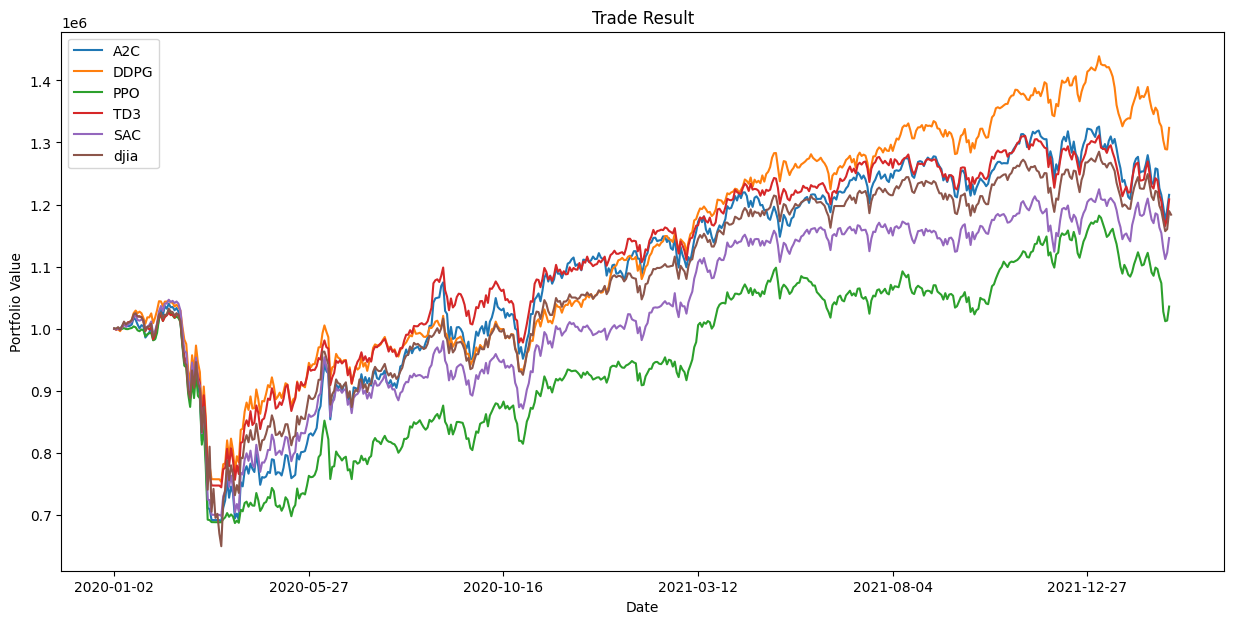

In [37]:
plt.rcParams["figure.figsize"] = (15,7)
fig, ax = plt.subplots(1, 1)
result.plot(ax=ax)

ax.set_title("Trade Result")
ax.set_ylabel("Portfolio Value")
ax.set_xlabel("Date")

fig.savefig("figs/all_methods.pdf", format="pdf")